# **Instructions**

This document is a template, and you are not required to follow it exactly. However, the kinds of questions we ask here are the kinds of questions we want you to focus on. While you might have answered similar questions to these in your project presentations, we want you to go into a lot more detail in this write-up; you can refer to the Lab homeworks for ideas on how to present your data or results. 

You don't have to answer every question in this template, but you should answer roughly this many questions. Your answers to such questions should be paragraph-length, not just a bullet point. You likely still have questions of your own -- that's okay! We want you to convey what you've learned, how you've learned it, and demonstrate that the content from the course has influenced how you've thought about this project.

# Project Name
Project mentor: Guanghui Qin

Shichang Ke <ske1@jh.edu>, Alex Zhang <azhang41@jh.edu>, Zhenzhen Wang <zwang218@jh.edu>

Link_to_git_repo: https://github.com/JasmineZhen218/Sign-Language-Identification

# Outline and Deliverables

List the deliverables from your project proposal. For each uncompleted deliverable, please include a sentence or two on why you weren't able to complete it (e.g. "decided to use an existing implementation instead" or "ran out of time"). For each completed deliverable, indicate which section of this notebook covers what you did.

If you spent substantial time on any aspects that weren't deliverables in your proposal, please list those under "Additional Work" and indicate where in the notebook you discuss them.

### Uncompleted Deliverables
1. "Would like to complete #2": Improve the pipeline so that it can preprocess raw videos of people making ASL alphabet gestures. We are able to convert videos to images, but we have not tested the extracted frames on the model.
2. "Would like to complete #3": Train the model to recognize letter by letter from a video (including J and Z which require motion). We did not have time to write functions that can process the output of testing on videos.


### Completed Deliverables
1. "Must Accomplish #1":  Build a multi-class classifier for cropped images of various users and backgrounds for American Sign Language letters [in "Multi-class classifier" below](#scrollTo=tay3Uu7M0kPa) 
2. "Must Accomplish #2": Create a real-world dataset (picture with hands and other irrelevant backgrounds) [in "Datasets" below](#scrollTo=zFq-_D0khnhh)
3. "Must Accomplish #3": Create a pipeline for the preprocessing of raw images (use sliding window approach to isolate the region with hand [in "Object detector" below](#scrollTo=-FvmrwXVDWrZ)
4. "Expected to Accomplish #1": Build a binary classifier to see if an image contains a hand with ASL gesture [in "Binary Classifier" below](#scrollTo=IWBF0WZu0-pU)
5. "Expected to Accomplish #2": Combine the preprocessing pipeline, the binary classifier and the multiclass classifier (implemented in hand_localizer.py)
6. "Expected to Accomplish #3": Improve our model so that it can classify the new dataset. [We used external dataset](#scrollTo=Bb0tVQGXyk7S&line=7&uniqifier=1)in multi-class classifier.
7. "Would like to Accomplish #1": Write functions to make the model take multiple inputs and output the classification in order.


### Additional Deliverables
1. We wrote functions to preprocess video files so that it can be trained and tested by our models.
2. We discuss training our random forest and SVM baseline [in "Baselines" below](#scrollTo=oMyqHUa0jUw7&line=5&uniqifier=1).

## Explanations
1. "Would like to Accomplish #1": This deliverable is incoperated into each model through a few lines of code, so it technically does not count as a seperate deliverable.

# Preliminaries

## What problem were you trying to solve or understand?

What are the real-world implications of this data and task?
- American Sign Language (ASL) is the primary language of many North Americans who are deaf and hard of hearing. Identification and automatic translation will make their communication with others much easier.

How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks?
- Backbone of the pipeline would be a multiclass classifier.

What makes this problem unique?
- This is a pipeline for the ASL identification on real-world data

What ethical implications does this problem have?
- There might be some copyright/privacy issue with data collection


## Dataset(s)

Describe the dataset(s) you used.

<!-- How were they collected?

Why did you choose them?

How many examples in each? -->

- [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)
  * How were they collected? -- This is a drop-in replacement for MNIST for hand Gesture Recognition. It is generated and enriched from a [hand gesture image data](https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn) represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. 
  * Why did you choose them? -- This is a benchmark dataset for ASL identification. The dataset format is patterned to match closely with the classic MNIST.
  * How many examples in each? -- 27455 training + 27455 testing

- [Real-world Sign Language Gesture Images Dataset](https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn)
  * How were they collected? -- This is the dataset that [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) generated from. Seven users repeated the gesture against different backgrounds.
  * Why did you choose them? -- Images in this dataset better represents the real-world scenario, since they contains not only hands, but also irrelevant background (heads, clothes, blackboards)
  * How many examples in each? -- 1704 images


Mounted at /content/drive
Training data: (27455, 784) (27455,)
Validation data: (7172, 784) (7172,)


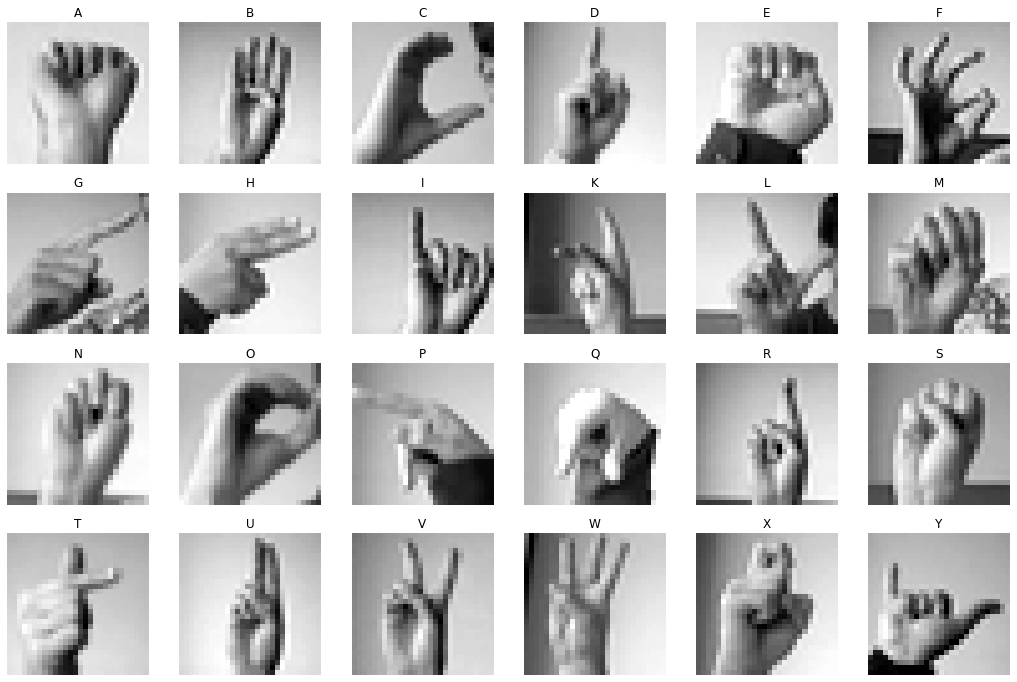

In [ ]:
# Load your data and print 2-3 examples
from google.colab import drive
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
drive.mount('/content/drive')
dir = '/content/drive/My Drive/ML_final/'
# load the data 
mapping = {
    'A': 0, 'B': 1, 'C': 2,'D': 3, 'E': 4, 'F': 5,'G': 6, 'H': 7, 'I': 8,'K': 9, 'L': 10,'M': 11,'N': 12,'O': 13,'P': 14,'Q': 15,'R': 16,'S': 17, 'T': 18,'U': 19,'V': 20,'W': 21,'X': 22,'Y': 23,
     0:'A', 1:'B', 2:'C',3:'D', 4:'E', 5:'F',6:'G', 7:'H', 8:'I',9:'K', 10:'L',11:'M', 12:'N',13:'O',14:'P',15:'Q',16:'R',17:'S',18:'T',19:'U',20:'V',21:'W',22:'X',23:'Y'}
train = pd.read_csv(dir+'Sign_MNIST/sign_mnist_train.csv')
test = pd.read_csv(dir+'Sign_MNIST/sign_mnist_test.csv')
train.label = [i if i <= 8 else i-1 for i in train.label]
test.label = [i if i <= 8 else i-1 for i in test.label]
# extract features and labels
train_x = train.iloc[:,1:].to_numpy()
train_y = train.iloc[:,0].to_numpy()
dev_x = test.iloc[:,1:].to_numpy()
dev_y = test.iloc[:,0].to_numpy()
print("Training data:", train_x.shape, train_y.shape)
print("Validation data:", dev_x.shape, dev_y.shape)
# Have a look at examples
f, ax = plt.subplots(4,6,figsize = (18,12))
for i in range(4):
  for j in range(6):
    label = i*6 + j
    example = train_x[train_y == label][0]
    ax[i,j].imshow(example.reshape((28,28)),  cmap = 'gray')
    ax[i,j].set_title(mapping[label])
    ax[i,j].set_axis_off()

There are 7 Users, generating 1687 examples in all


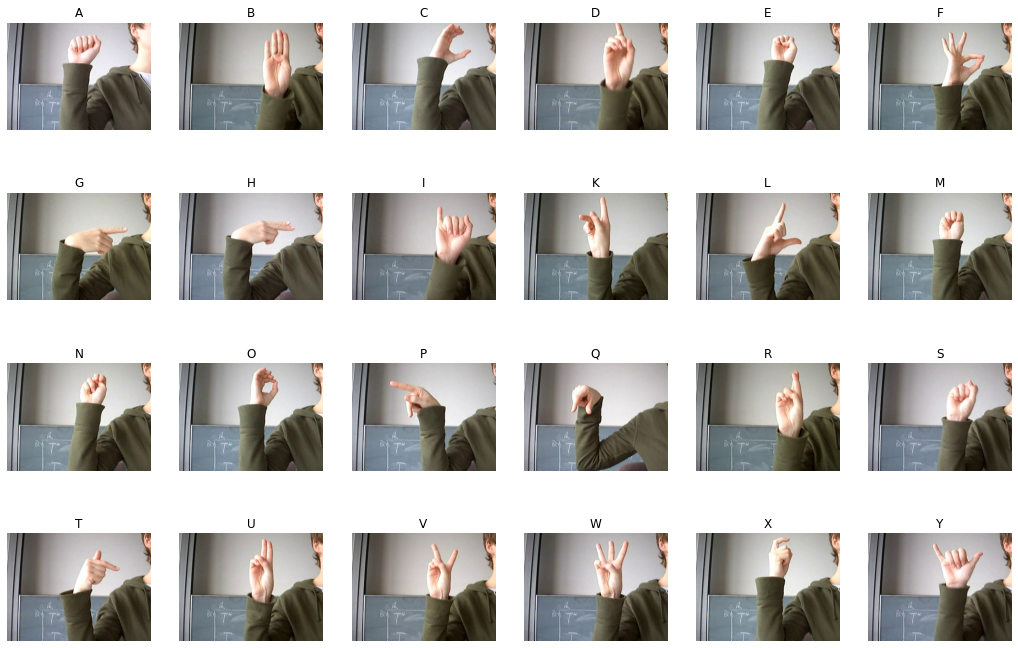

In [ ]:
import imageio
import os
# load the data 
Names = {
    'user_3':os.listdir(dir+'Sliding_window/user_3'),
    'user_4':os.listdir(dir+'Sliding_window/user_4'),
    'user_5':os.listdir(dir+'Sliding_window/user_5'),
    'user_6':os.listdir(dir+'Sliding_window/user_6'),
    'user_7':os.listdir(dir+'Sliding_window/user_7'),
    'user_9':os.listdir(dir+'Sliding_window/user_9'),
    'user_10':os.listdir(dir+'Sliding_window/user_10'),
}
print("There are {} Users, generating {} examples in all".format(len([len(Names[user]) for user in Names.keys()]), sum([len(Names[user]) for user in Names.keys()])))
# Have a look at examples
f, ax = plt.subplots(4,6,figsize = (18,12))
for i in range(4):
  for j in range(6):
    label = i*6 + j
    example= imageio.imread(dir+'Sliding_window/user_3/'+mapping[label]+'0.jpg')
    ax[i,j].imshow(example)
    ax[i,j].set_title(mapping[label])
    ax[i,j].set_axis_off()

## Pre-processing

What features did you use or choose not to use? Why?

- We choose to use pixels of images. We will implement a CNN-based multi-class classifier, which should be able to extract features from raw images, and no further feature engineering is needed.

If you have categorical labels, were your datasets class-balanced?
- Yes, it's balanced

How did you deal with missing data? What about outliers?
- No such problems in our datasets

What approach(es) did you use to pre-process your data? Why?
- We use data normalization. To be more specific, image = (image - mean)/std. Here, mean and std are calculated **only** in the training set. We conducted the normalization to deal with the potential distribution shift across training, validation and test data.

Are your features continuous or categorical? How do you treat these features differently?
- We only have continuous features -- pixel value ranging from 0-255.

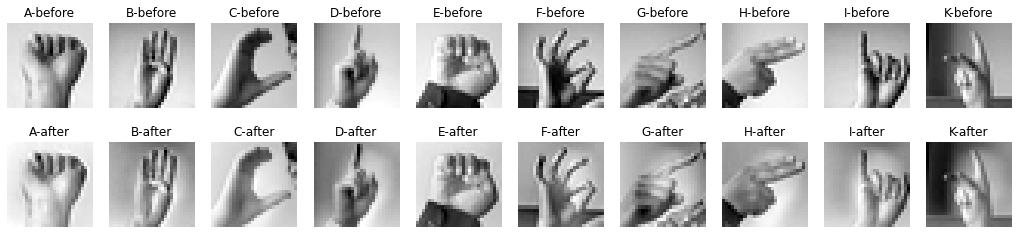

In [ ]:
# For those same examples above, what do they look like after being pre-processed?
# normalize
x_mean, x_std = np.mean(train_x, axis=0), np.std(train_x, axis=0)
train_x_n =  (train_x - x_mean)/x_std
dev_x_n = (dev_x -  x_mean)/x_std
f, ax = plt.subplots(2,10,figsize = (18,4))
for i in range(10):
    label = i
    example_before = train_x[train_y == label][0]
    example_after = train_x_n[train_y == label][0]
    ax[0,i].imshow(example_before.reshape((28,28)),  cmap = 'gray')
    ax[0,i].set_title(mapping[label]+'-before')
    ax[0,i].set_axis_off()
    ax[1,i].imshow(example_after.reshape((28,28)),  cmap = 'gray')
    ax[1,i].set_title(mapping[label]+'-after')
    ax[1,i].set_axis_off()

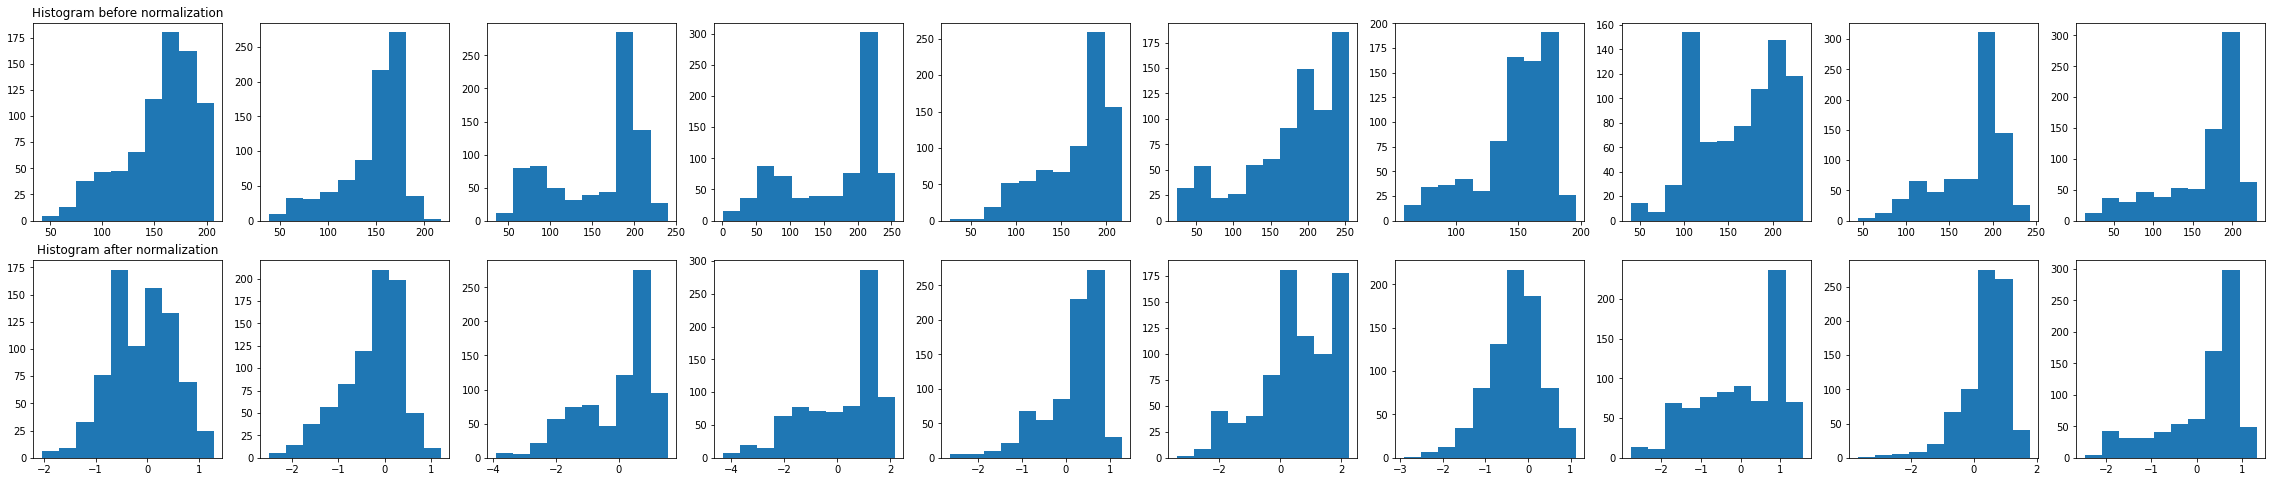

In [ ]:
# Visualize the distribution of your data before and after pre-processing.
#   You may borrow from how we visualized data in the Lab homeworks.
import random
f, ax = plt.subplots(2,10, figsize = (40,8))
for i in range(10):
  ax[0,i].hist(train_x[i])
  ax[1,i].hist(train_x_n[i])
  if i == 0:
    ax[0,i].set_title("Histogram before normalization")
    ax[1,i].set_title("Histogram after normalization")

The following code shows some random pictures used in hand classification

Mounted at /content/drive


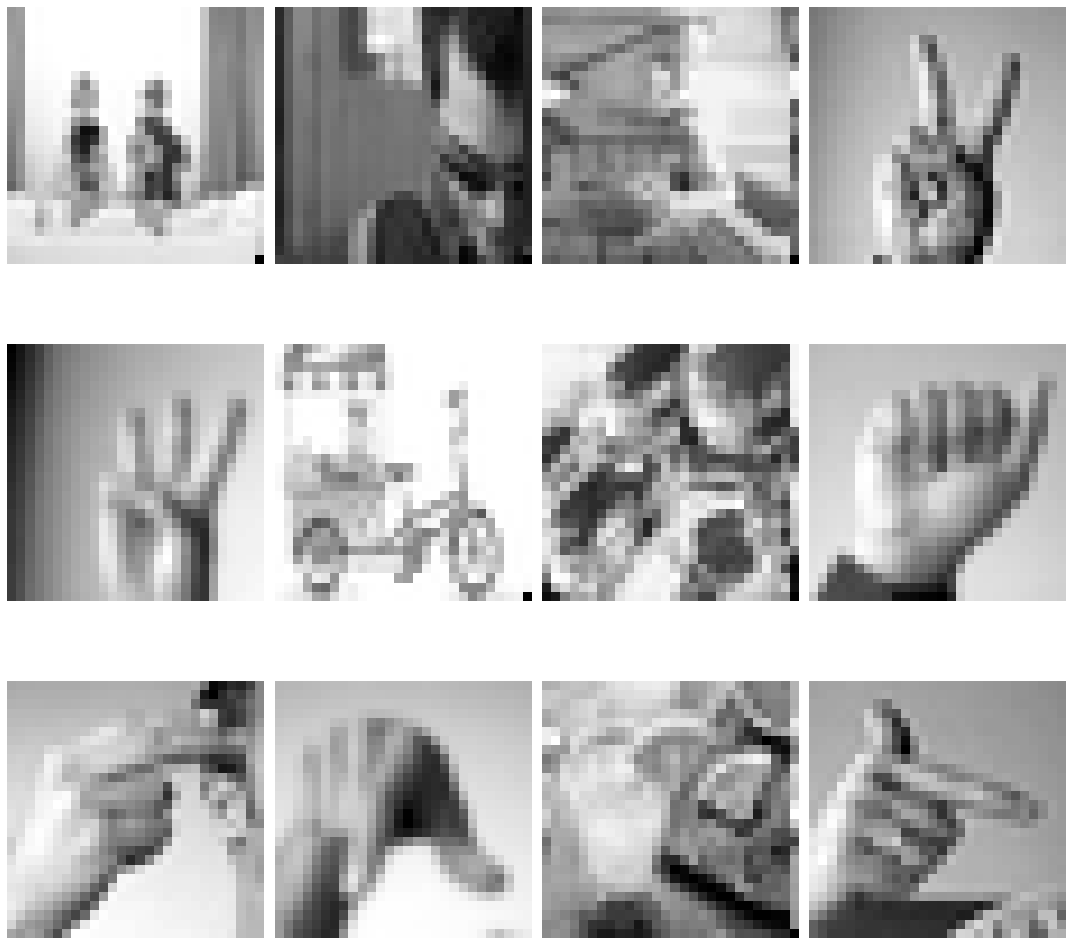

In [ ]:
from PIL import Image
import cv2
import os
%matplotlib inline
import pandas as pd 
import numpy as np 
import plotly.express as px
import matplotlib.pylab as plt
from pandas.api.types import CategoricalDtype
from google.colab import drive
drive.mount('/content/drive')
IMG_DIR = "/content/drive/MyDrive/ML_final/Sign_MNIST/images"
img_array_total = np.empty([2046,784])
i = 0
for img in os.listdir(IMG_DIR):
    img_array = cv2.imread(os.path.join(IMG_DIR,img), cv2.IMREAD_GRAYSCALE)
    if img_array is None:
      continue
    img_pil = Image.fromarray(img_array)
    img_28x28 = np.array(img_pil.resize((28, 28), Image.ANTIALIAS))

    img_array = (img_28x28.flatten())

    img_array  = img_array.reshape(-1,1).T
    img_array_total[i] = img_array
    i = i+ 1
    
zero_ish = np.zeros((2046,), dtype=int)
img_array_total = np.concatenate((zero_ish[:, np.newaxis], img_array_total), axis=1)
arr = ['label']
for i in range(784):
  arr.append('pixel'+str(i))
test_rnd_image = pd.DataFrame(img_array_total,columns = arr)
test_rnd_image = test_rnd_image.astype(int)

train_bin = pd.read_csv("/content/drive/MyDrive/ML_final/Sign_MNIST/sign_mnist_train.csv")
test_bin = pd.read_csv("/content/drive/MyDrive/ML_final/Sign_MNIST/sign_mnist_train.csv")

test_digit_bin = pd.read_csv("/content/drive/MyDrive/ML_final/Sign_MNIST/test.csv")
test_fashion_bin = pd.read_csv("/content/drive/MyDrive/ML_final/Sign_MNIST/fashion-mnist_test.csv")

#augment the x_test by 1 dim
test_bin['label'] = 1
test_digit_bin['label'] = 0
test_fashion_bin['label'] = 0
train_bin['label'] = 1

train_bin = train_bin[:2046]



train_bin = pd.concat([train_bin, test_rnd_image])
test_bin = pd.concat([test_bin,test_digit_bin,test_fashion_bin])

train_bin = train_bin.fillna(0)
test_bin = test_bin.fillna(0)

train_label_bin = np.zeros([29500,1])
test_label_bin = np.zeros([65455,1])

test_bin = test_bin.sample(frac = 1)
train_bin = train_bin.sample(frac = 1)


for i in range(2046):
  test_label_bin[i] =1 

test_bin = test_bin.iloc[: , :-1]
train_bin = train_bin.iloc[: , :-1]

train_x_bin = train_bin.drop("label",axis=1)
train_y_bin= train_bin["label"]
test_x_bin = test_bin.drop("label",axis=1)
test_y_bin= test_bin["label"]

# get some random index fro the train
train_x_bin = train_x_bin.to_numpy()
train_x_bin = train_x_bin.reshape(-1,28,28,1)


random_index = np.random.choice(range(len(train_x_bin)),12)
# show the 12 random images 
plt.figure(figsize=(15,15))
plt.title("Some Random Training Images")
for i in range(12):
    plt.subplot(3,4,i+1)
    img = train_x_bin[random_index[i]]
    plt.imshow(img[:,:,0],cmap=plt.get_cmap("gray"))
    plt.axis("off")
plt.tight_layout()
plt.show() 

## Video to frame

This is a pre-processing step for video files. We can extract frames from a video file to feed the images into our pipeline, since the required inputs for our classifiers are in image format. Upon further refinement, we believe it can be used to created ASL video translation.

In [ ]:
import cv2
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/My Drive/ML_final/'

Mounted at /content/drive


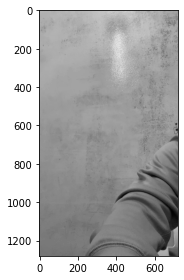

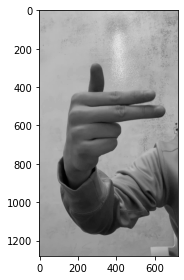

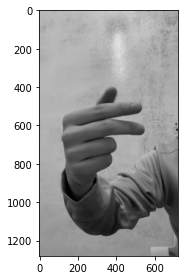

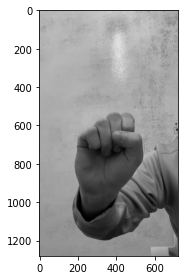

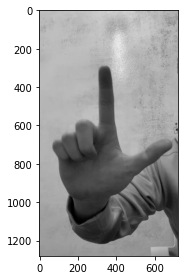

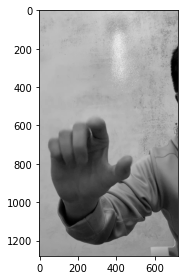

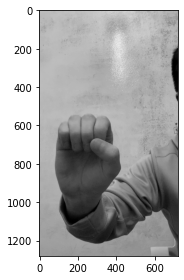

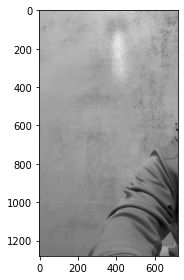

In [ ]:

# Program To Read video
# and Extract Frames
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

  
# Function to extract frames
def FrameCapture(pathin, pathout):
      
    # Path to video file
    vidObj = cv2.VideoCapture(pathin)
  
    # Used as counter variable
    count = 0
  
    # checks whether frames were extracted
    success, image = vidObj.read()
    while success:
  
        cv2.imwrite(pathout+"/%d.jpg" % count, image)
        image = rgb2gray(image)
        if count%30 == 0:

          plt.imshow(image, cmap='gray')
          plt.tight_layout()
          plt.show()
        count += 1
        success, image = vidObj.read()
  
FrameCapture("/content/drive/MyDrive/ML_final/IMG_0358.MP4", "/content/drive/MyDrive/ML_final/External_test_data")

# Models and Evaluation

## Multi-class classifier (ASL identification)

### Experimental Setup

How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?
- Accuracy. This is a multi-class classification problem.

What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?
- Cross entropy. We only use this loss function. This is the standard loss function used in CNN and classification task.

How did you split your data into train and test sets? Why?
- We don't need to. Sign Language MNIST split it for us.


In [ ]:
# Evaluation metrics
import cv2 as cv
from scipy import ndimage
import torch
import torch.nn.functional as F
def approx_train_acc_and_loss(model, train_data : np.ndarray, train_labels : np.ndarray) -> np.float64:
    idxs = np.random.choice(len(train_data), 4000, replace=False)
    x = torch.from_numpy(train_data[idxs].astype(np.float32))
    y = torch.from_numpy(train_labels[idxs].astype(np.int))
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    return accuracy(train_labels[idxs], y_pred.numpy()), loss.item()

def dev_acc_and_loss(model, dev_data : np.ndarray, dev_labels : np.ndarray) -> np.float64:
    x = torch.from_numpy(dev_data.astype(np.float32))
    y = torch.from_numpy(dev_labels.astype(np.int))
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    return accuracy(dev_labels, y_pred.numpy()), loss.item()

def predict(model, dev_data : np.ndarray):
    x = torch.from_numpy(dev_data.astype(np.float32))
    logits = model(x)
    y_pred = torch.max(logits, 1)[1]
    return logits, y_pred

def accuracy(y : np.ndarray, y_hat : np.ndarray) -> np.float64:
    return np.sum(y == y_hat)/len(y)

### Baselines 

What baselines did you compare against? Why are these reasonable?
- SVM and random forest. They are well-established and classifical methods in the multi-class classfication methods.


In [ ]:
# SVM
from sklearn.svm import SVC
import pickle
# fit
clf_svm = SVC(gamma='auto')
clf_svm.fit(train_x_n, train_y)

SVC(gamma='auto')

In [ ]:
# Random Forest
from numpy.fft import rfft2
from sklearn.ensemble import RandomForestClassifier
# fit
clf_rf = RandomForestClassifier( random_state=0)
clf_rf.fit(train_x_n, train_y)

RandomForestClassifier(random_state=0)

### Methods

What methods did you choose? Why did you choose them?
- CNN. It shows exceptional success in image classification tasks in many domains. It's reasonable to consider it should still work in the sign language identification problem. It also has a strong link with the lectures and course contents.

How did you train these methods, and how did you evaluate them? Why?
- Training: We implemented the CNN model using the pytorch library, trained the model using a cross-entropy loss, and updated parameters using the Adam optimizer. 
- Evaulation: We traced the loss and accuracy during training, and used accuracy as the evaulation metrics for the final model.

Which methods were easy/difficult to implement and train? Why?
- SVM and random forests are east to implement, since the pipeline and function are kind of standard in the Sklearn library.
- CNN is comparatively difficult to implement, since we have to decide reasonable model architecture by ourselves.

For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?
- Learning rate and batch size are tunable hyperparamters. They are not very sensitive parameters, and they affect the converage speed more than the performance.



In [ ]:
# Code for training models, or link to your Git repository
class BestModel(torch.nn.Module):
    def __init__(self, input_height, input_width, n_classes):
        super().__init__()
        self.input_height = input_height
        self.input_width= input_width
        self.n_classes = n_classes
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, 3),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(2),
            torch.nn.Conv2d(16, 32, 3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(2),
        )    
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(1024, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,self.n_classes)
        ) 
    def forward(self, x): 
        x = torch.reshape(x, (-1, self.input_height, self.input_width))
        x = torch.unsqueeze(x, 1)
        x = self.feature_extractor(x)
        x = torch.reshape(x, (x.shape[0], -1)) # flatten
        output = self.classifier(x)
        return output

HEIGHT, WIDTH = 28, 28
LEARNING_RATE = 0.001
EPOCHS = 3000
BATCH_SIZE = 64
model = BestModel(input_height = HEIGHT, input_width= WIDTH, n_classes= 24)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8)
Train_acc, Train_loss = [], []
Dev_acc, Dev_loss = [], []
for step in range(EPOCHS):
  i = np.random.choice(train_x.shape[0], size=BATCH_SIZE, replace=False)
  x = torch.from_numpy(train_x[i].astype(np.float32))
  y = torch.from_numpy(train_y[i].astype(np.int))        
  # Forward pass: Get logits for x
  logits = model(x)
  # Compute loss
  loss = F.cross_entropy(logits, y)
  # Zero gradients, perform a backward pass, and update the weights.
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()

  # log model performance every 100 epochs
  if step % 100 == 0:
    train_acc, train_loss = approx_train_acc_and_loss(model, train_x, train_y)
    dev_acc, dev_loss = dev_acc_and_loss(model, dev_x, dev_y)
    print("On step {}:\tTrain loss {:3f}\t|\tDev acc is {:.3f}".format(step, train_loss, dev_acc))
    Train_acc.append(train_acc)
    Train_loss.append(train_loss)
    Dev_acc.append(dev_acc)
    Dev_loss.append(dev_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecate

On step 0:	Train loss 3.836670	|	Dev acc is 0.029
On step 100:	Train loss 1.052704	|	Dev acc is 0.619
On step 200:	Train loss 0.373532	|	Dev acc is 0.743
On step 300:	Train loss 0.136263	|	Dev acc is 0.846
On step 400:	Train loss 0.025124	|	Dev acc is 0.879
On step 500:	Train loss 0.024114	|	Dev acc is 0.882
On step 600:	Train loss 0.021531	|	Dev acc is 0.892
On step 700:	Train loss 0.005121	|	Dev acc is 0.902
On step 800:	Train loss 0.007521	|	Dev acc is 0.906
On step 900:	Train loss 0.015398	|	Dev acc is 0.904
On step 1000:	Train loss 0.064042	|	Dev acc is 0.861
On step 1100:	Train loss 0.001860	|	Dev acc is 0.909
On step 1200:	Train loss 0.000507	|	Dev acc is 0.918
On step 1300:	Train loss 0.000762	|	Dev acc is 0.922
On step 1400:	Train loss 0.000711	|	Dev acc is 0.922
On step 1500:	Train loss 0.000242	|	Dev acc is 0.923
On step 1600:	Train loss 0.006490	|	Dev acc is 0.910
On step 1700:	Train loss 0.000630	|	Dev acc is 0.924
On step 1800:	Train loss 0.000426	|	Dev acc is 0.921
On st

[Text(0.5, 0, 'epoch')]

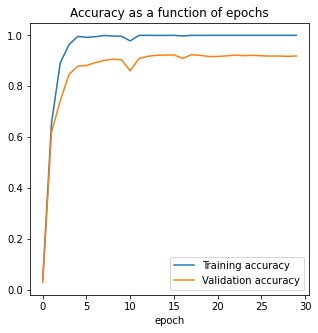

In [ ]:
# Show plots of how these models performed during training.
f, ax = plt.subplots(figsize = (5,5))
ax.plot(Train_acc, label = 'Training accuracy')
ax.plot(Dev_acc, label = 'Validation accuracy')
ax.legend()
ax.set_title('Accuracy as a function of epochs')
ax.set(xlabel = 'epoch')

### Results

Show tables comparing your methods to the baselines.

| Method        | Train (acc) | Validation (acc) |
| --- | --- | --- |
| Random Forest | 1.0 | 0.81 |
| SVM           | 1.0 | 0.85 |
| CNN           | 1.0 | 0.94 |

What about these results surprised you? Why?
- CNN significantly outperforms other baselines. These results does not "surprise" me, since CNN has been shown be the state-of-art method for multi-class classification task.

Did your models over- or under-fit? How can you tell? What did you do to address these issues?
- The CNN does show slight overfitting during training, as the loss function of validation shows. We choose to use clever learning rate scheduler to address it.To be more specific, we decayed the learning rate to 80% every 500 epochs. 

What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data?  
- The evaulation results shows that ASL can be identified very accurately on the Sign Language MNIST set. However, I don't expect this model behave as well as it behaves here on the external dataset. I think further fine tuning and transfer learning are needed to obtain good results on new data.

In [ ]:
# Show plots or visualizations of your evaluation metric(s) on the train and test sets.
#   What do these plots show about over- or under-fitting?
#   You may borrow from how we visualized results in the Lab homeworks.
#   Are there aspects of your results that are difficult to visualize? Why?

df = pd.DataFrame({})
index = 0

with open(dir+'svm.sav', 'rb') as handle:
  dat = pickle.load(handle)
handle.close()
clf_svm = dat['model']
train_y_hat = clf_svm.predict(train_x_n)
dev_y_hat = clf_svm.predict(dev_x_n)
print("SVM, Accuracy on training set is {:.2f}".format(np.mean(train_y_hat == train_y)))
print("SVM, Accuracy on dev set is {:.2f}".format(np.mean(dev_y_hat == dev_y)))
df.loc[index, 'method'] =  'SVM'
df.loc[index, 'accuracy'] = np.mean(train_y_hat == train_y)
df.loc[index, 'dataset'] = 'training'
index += 1
df.loc[index, 'method'] =  'SVM'
df.loc[index, 'accuracy'] = np.mean(dev_y_hat == dev_y)
df.loc[index, 'dataset'] = 'validation'
index += 1

with open(dir+'rf.sav', 'rb') as handle:
  dat = pickle.load(handle)
handle.close()
clf_rf = dat['model']
train_y_hat = clf_rf.predict(train_x_n)
dev_y_hat = clf_rf.predict(dev_x_n)
print("Random Forest, Accuracy on training set is {:.2f}".format(np.mean(train_y_hat == train_y)))
print("Random Forest, Accuracy on dev set is {:.2f}".format(np.mean(dev_y_hat == dev_y)))
df.loc[index, 'method'] =  'Random Forest'
df.loc[index, 'accuracy'] = np.mean(train_y_hat == train_y)
df.loc[index, 'dataset'] = 'training'
index += 1
df.loc[index, 'method'] =  'Random Forest'
df.loc[index, 'accuracy'] = np.mean(dev_y_hat == dev_y)
df.loc[index, 'dataset'] = 'validation'
index += 1


SVM, Accuracy on training set is 1.00
SVM, Accuracy on dev set is 0.85
Random Forest, Accuracy on training set is 1.00
Random Forest, Accuracy on dev set is 0.81


In [ ]:
model = BestModel(input_height = HEIGHT, input_width= WIDTH, n_classes= 24)
model.load_state_dict(torch.load(dir+'CNN.pth'))
# train_acc, _ = dev_acc_and_loss(model, train_x, dev_y)
dev_acc, _ = dev_acc_and_loss(model, dev_x, dev_y)
print("CNN, Accuracy on training set is {:.2f}".format(train_acc))
print("CNN Forest, Accuracy on dev set is {:.2f}".format(dev_acc))
df.loc[index, 'method'] =  'CNN'
df.loc[index, 'accuracy'] = train_acc
df.loc[index, 'dataset'] = 'training'
index += 1
df.loc[index, 'method'] =  'CNN'
df.loc[index, 'accuracy'] = dev_acc
df.loc[index, 'dataset'] = 'validation'
index += 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CNN, Accuracy on training set is 1.00
CNN Forest, Accuracy on dev set is 0.94


Text(0.5, 1.0, 'Comparsion of different methods')

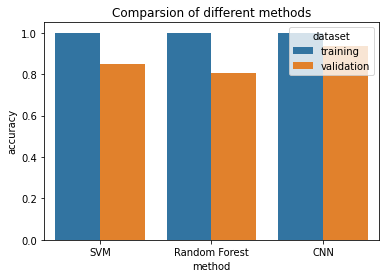

In [ ]:
import seaborn as sns
f, ax = plt.subplots()
ax = sns.barplot(x="method", y="accuracy", data=df, hue = 'dataset')
ax.set_title("Comparsion of different methods")

## Binary Classifier (hand or not)

### Experimental Setup

How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?
 - Accuracy, because this is a binary classification problem.

What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?

  - Binary cross entropy, this is standard loss function for binary classification so we didn't try other loss functions.

How did you split your data into train and test sets? Why?
  - For the pictures containing hands, we used the same source. But for pictures not containing hands, we used random pictures from different sources, instead of using all pictures from the same dataset-- this is to make sure the model will not adapt to only one particular dataset.


In [ ]:
#setup

from sklearn.model_selection import train_test_split


dev_x_bin,blind_x_bin ,dev_y_bin, blind_y_bin = train_test_split(test_x_bin,test_y_bin,test_size=.8,stratify=test_y_bin)

test_classes_bin= blind_y_bin
dev_clasees_bin = dev_y_bin


dev_x_bin   = dev_x_bin.to_numpy()
blind_x_bin    = blind_x_bin.to_numpy()

train_x_bin = train_x_bin.reshape(-1,28,28,1)
dev_x_bin   = dev_x_bin.reshape(-1,28,28,1)
blind_x_bin    = blind_x_bin.reshape(-1,28,28,1)


### Baselines 

What baselines did you compare against? Why are these reasonable?

- We use zero rule as the baseline. This is a common baseline used in binary classification, and it is particularly good in this case because we have an imbalance of testing data- there are more non hand pictures than hand pictures in our testing data.

### Methods

What methods did you choose? Why did you choose them?
- We choose to use a 1- layer convolutional neural network with a pooling layer. This is because 1 - layer convolutional neural network is fast to train and gives good accuracy. 

How did you train these methods, and how did you evaluate them? Why?

 - We trained these models using the Adam optimizer, choose cross entropy as the loss function. We evaluated by looking at the training and testing accuracy: a high accuracy means the model is good most of the time. 

Which methods were easy/difficult to implement and train? Why?

- This is a easy model to train- there is no need of tuning the hyper-parameters in order to get a good accuracy. 

For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?

- Learning rate and batch size can be evaluated, but the model performs well without needing to adjust them.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
64/64 [==============================] - 15s 222ms/step - loss: 4.1883 - accuracy: 0.7507 - val_loss: 0.0857 - val_accuracy: 0.9784
Epoch 2/10
64/64 [==============================] - 11s 180ms/step - loss: 0.3357 - accuracy: 0.8854 - val_loss: 0.1028 - val_accuracy: 0.9698
Epoch 3/10
64/64 [==============================] - 12s 183ms/step - loss: 0.2174 - accuracy: 0.9228 - val_loss: 0.0840 - val_accuracy: 0.9782
Epoch 4/10
64/64 [==============================] - 13s 203ms/step - loss: 0.1864 - accuracy: 0.9360 - val_loss: 0.0899 - val_accuracy: 0.9780
Epoch 5/10
64/64 [==============================] - 11s 180ms/step - loss: 0.1760 - accuracy: 0.9360 - val_loss: 0.1579 - val_accuracy: 0.9661
Epoch 6/10
64/64 [==============================] - 12s 182ms/step - loss: 0.1337 - accuracy: 0.9555 - val_loss: 0.1081 - val_accuracy: 0.9748
Epoch 7/10
64/64 [==============================] - 11s 180ms/step - loss: 0.1290 - accuracy: 0.9580 - val_loss: 0.0382 - val_accuracy: 0.9925

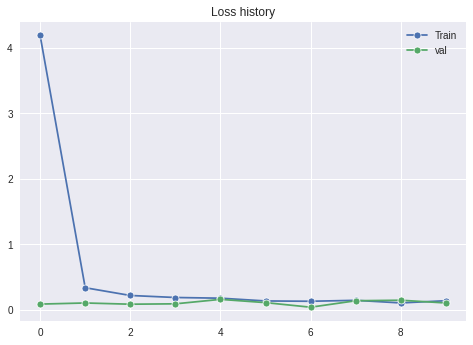

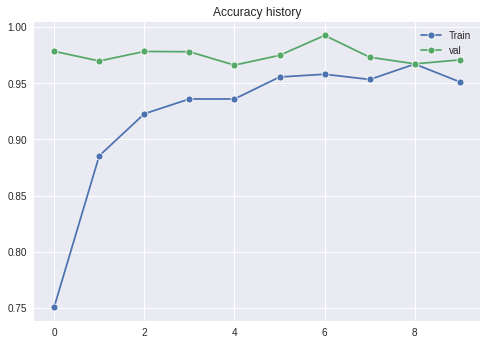

In [ ]:
# Show plots of how these models performed during training.
#  For example, plot train loss and train accuracy (or other evaluation metric) on the y-axis,
#  with number of iterations or number of examples on the x-axis.

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
import pickle
import seaborn as sns 



labels = train_bin["label"].value_counts().sort_index(ascending=True)


def ResNet50(input_shape = (28, 28, 1), classes =len(labels) ):
    
    # Define the input as a tensor with shape input_shape
    X_input = tf.keras.Input(input_shape)
    
    # Zero-Padding
    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1))(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(classes, activation='sigmoid')(X)

    
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X)

    return model
model =ResNet50()


train_y_bin = pd.pandas.get_dummies(train_y_bin)
dev_y_bin   = pd.pandas.get_dummies(dev_y_bin)
blind_y_bin = pd.pandas.get_dummies(blind_y_bin)

model.compile(optimizer="adam",metrics=["accuracy"],loss = "binary_crossentropy")

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

best_model =tf.keras.callbacks.ModelCheckpoint("best.h5",monitor="val_accuracy")
history = model.fit_generator(datagen.flow(train_x_bin,train_y_bin,batch_size=64),validation_data =datagen.flow(dev_x_bin,dev_y_bin),epochs =10,callbacks=[best_model])

model.load_weights("best.h5")

def dumpclassifier(filename,model):
    
    with open(filename, 'wb') as fid:
        pickle.dump(model, fid) 


dumpclassifier('handClassifier.pkl',model)
X = range(len(history.history["loss"]))
train_loss = history.history["loss"]
val_loss =history.history["val_loss"]
train_acc = history.history["accuracy"]
val_accuracy =history.history["val_accuracy"]


plt.style.use("seaborn")
plt.figure()
plt.title("Loss history")
sns.lineplot(x=X,y=train_loss,label="Train",marker="o")
sns.lineplot(x=X,y=val_loss,label="val",marker="o")
plt.show()
plt.figure()
plt.title("Accuracy history")
sns.lineplot(x=X,y=train_acc,label="Train",marker="o")
sns.lineplot(x=X,y=val_accuracy,label="val",marker="o")
plt.show()

### Results

Show tables comparing your methods to the baselines.

What about these results surprised you? Why?

The fact that testing accuracy is high within the epoch suprised me. I thought the testing accuracy should be about the same as training accuracy.

Did your models over- or under-fit? How can you tell? What did you do to address these issues?

I don't think the model under/ over fit. To prevent the model tuning to a specific kind of non-hand pictures, I made sure the dataset contains a variety of non-hand pictures, thus there ought to be no overfitting. The high train and testing accuracy can confirm this.

What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data? 

The models can classify the hand or non-hand pictures accurately, so there must be some unique features in hand pictures that distinguishes it from other pictures. If we use an external dataset that has other objects in hand pictures, however, the model might not perform so well. 

In [ ]:
# Show plots or visualizations of your evaluation metric(s) on the train and test sets.
#   What do these plots show about over- or under-fitting?
#   You may borrow from how we visualized results in the Lab homeworks.
#   Are there aspects of your results that are difficult to visualize? Why?


#this is the baseline: # of nonhand pictures / # total pictures
baseline_acc_training = 2026/4052
baseline_acc_testing = 1- 27455/ 65455

print(baseline_acc_training)
print(baseline_acc_testing)
print(train_acc[9])
print(val_accuracy[9])

0.5
0.5805515239477503
0.9511241316795349
0.9707432389259338






|   Train/Test  | Method Accuracy       | Baseline Accuracy |
| --- | --- | --- |
| Training| 0.951 | 0.5 |
| Testing | 0.97  | 0.581 |

## Object detector (Hand localizer)

### Experimental Setup

How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?
- We used manually selected bounding box for the hand in each image as the ground truth. We measured accuracy by calculating the number of flase positive pixles (number of pixels not in the box but is classified as being in the box). 

What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?
- We kept track of the numbe of flase posstive and try to minimize it within a reasonable number of iterations.

How did you split your data into train and test sets? Why?
- This depends on how the two classifiers splitted their datasets.


### Methods

What methods did you choose? Why did you choose them?
- We used a sliding window of different sizes to locate the hand in the image (we rescaled the image and kept the sliding window size constant in practice). The binary classifier was used to determine if the window contains a hand.

How did you train these methods, and how did you evaluate them? Why?
- We instruct the sliding window to locate a box with the maximum probability of having a hand in every different scale. Then we compute the final box coordinates by an algorithm from an paper called "Ensemble of Exemplar-SVMs for Object Detection and Beyond".

Which methods were easy/difficult to implement and train? Why?
- it was difficult to determine the right window size because we cannot possibly test every possible window size, but the paper provided a solution for us.

For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?
- the scales we used to rescale the images were: [1.25, 1.015625, 0.78125, 0.546875, 1.5625, 1.328125, 1.09375, 0.859375, 0.625, 1.40625, 1.171875, 0.9375, 0.703125, 1.71875, 1.484375 ]. If we include more scales, the accuracy will (probably) be higher, but the training will also take much more time. The iteration stops when the numbe of false positives is below a threshold.


In [ ]:
# Show plots of how these models performed during training.
#  For example, plot train loss and train accuracy (or other evaluation metric) on the y-axis,
#  with number of iterations or number of examples on the x-axis.
from skimage import data, io, filters
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import hog 

import numpy as np
import pandas as pd
import csv
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score,train_test_split
from os import listdir
from os.path import isfile, join
import random
from sklearn.model_selection import KFold
from sklearn.ensemble import  RandomForestClassifier
from skimage.transform import resize
from itertools import product
from multiprocessing import Pool
import time
import pickle
from sklearn.naive_bayes import MultinomialNB

import json
import time
import gzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ML_final/Sliding_window
# List directory contents
!ls -la 

/content/drive/MyDrive/ML_final/Sliding_window
total 107319
-rw------- 1 root root    19690 May  7 21:25 gesture_recognizer1.py
-rw------- 1 root root   508695 May  7 21:18 handDetector.pkl
drwx------ 2 root root     4096 Apr 26 03:37 .ipynb_checkpoints
-rw------- 1 root root      348 May  7 21:18 label_encoder.pkl
-rw------- 1 root root    57006 May  7 16:42 pipeline_final.ipynb
-rw------- 1 root root 60047178 May  7 21:18 signDetector.pkl
-rw------- 1 root root 49227774 May  7 21:18 sign_detector.pkl.gz
drwx------ 2 root root     4096 Apr 26 01:25 user_10
drwx------ 2 root root     4096 Apr 26 01:25 user_3
drwx------ 2 root root     4096 Apr 26 01:25 user_4
drwx------ 2 root root     4096 Apr 26 01:25 user_5
drwx------ 2 root root     4096 Apr 26 01:25 user_6
drwx------ 2 root root     4096 Apr 26 01:25 user_7
drwx------ 2 root root     4096 Apr 26 01:25 user_9


Train starts
Imageset, boundbox, hog_list,label_list Loaded!
Multiclass data loaded
Iteration 1 - No_of_false_positives: 967
Iteration 2 - No_of_false_positives: 934
Iteration 3 - No_of_false_positives: 4095
Iteration 4 - No_of_false_positives: 5665
Iteration 5 - No_of_false_positives: 1670
Iteration 6 - No_of_false_positives: 399
Iteration 7 - No_of_false_positives: 352
Iteration 8 - No_of_false_positives: 303
Iteration 9 - No_of_false_positives: 279
Iteration 10 - No_of_false_positives: 251
Iteration 11 - No_of_false_positives: 222
Iteration 12 - No_of_false_positives: 207
Iteration 13 - No_of_false_positives: 192
Iteration 14 - No_of_false_positives: 173
Iteration 15 - No_of_false_positives: 161
Iteration 16 - No_of_false_positives: 154
Iteration 17 - No_of_false_positives: 142
Iteration 18 - No_of_false_positives: 129
Iteration 19 - No_of_false_positives: 121
Iteration 20 - No_of_false_positives: 113
Iteration 21 - No_of_false_positives: 108
Iteration 22 - No_of_false_positives: 10

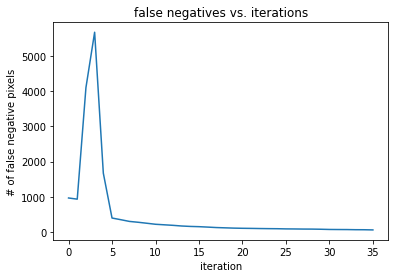

In [ ]:
%matplotlib inline
%run hand_localizer.py train

### Results

Show tables comparing your methods to the baselines.
- the graph is a historgram of the percentage overlap between predicted box and the labeled box with hand.

What about these results surprised you? Why?
- not very surpising because the number of false psotives in the training divided by the total area should be similar to the result shown. There sometimes will be a very low percentage of overlap, but we believes the frequency is well below the level of concern.

Did your models over- or under-fit? How can you tell? What did you do to address these issues?
- to make sure my model does not over-fit, I trained on images from different users and tested on different users

480
480
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture
In recognize_gesture


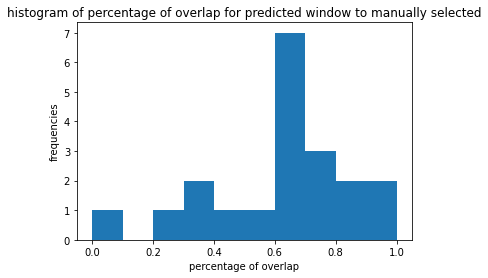

In [ ]:
%run hand_localizer.py test

# Discussion

## What you've learned

*Note: you don't have to answer all of these, and you can answer other questions if you'd like. We just want you to demonstrate what you've learned from the project.*

What concepts from lecture/breakout were most relevant to your project? How so?
- Deep learning(in particular, training image classification using convolutional network) and classification, because the backbone of our pipeline is a multiclass classifiers using CNN.

What aspects of your project did you find most surprising?
- We found the fact that some tiny difference in training and test dataset can produce surprising difference: the accuracy is really low when we use the training dataset from pre-existing projects versus and the test dataset produced by us. (We suspect the problem is that when we resize high resolution pictures taken by our phones to 28*28 pixelated pictures, the pixelated pictures no longer represent a sign).

What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?
- We learned that it’s important to have a balance of bias and variance. We focused on having a high accuracy for one dataset at first but later found out the model lacked generalization. This lesson would definitely transfer to other datasets/models because we believe it’s the ultimate dilemma for ML problems. 

What was the most helpful feedback you received during your presentation? Why?
- One of the groups suggested we use an RNN for real time video ASL translation, and we thought it would be very helpful to try it out if we had more time.

If you had two more weeks to work on this project, what would you do next? Why?
- We would try to make the pipeline more seamless because we want it to be as automatic as possible. Right now we have to run each section of the pipeline separately, we hope we can eventually input a video data and it can output the recognized letters automatically.
- Also, we want to train and test our models on more data, because we only used three sets of data. We hope to generalized our model so that it can do accurate ASL recognition for images with different qualities. Although data augmentation had been helpful, we still believe it’s essential to have a larger dataset, which means more time doing data gathering online/offline.